In [1]:
import json
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from ast import literal_eval
from multiprocessing import Pool
import re

from p4utils.utils.helper import load_topo

# os.chdir('/home/user/dds/netscope/')
os.chdir('/root/netscope-main/')


from analysis.reservoir import Reservoir
from analysis.algrithm import spectrum, diff
from analysis.utils import export_FSP, detect_abnormal_timespan, PPS
# from analysis.utils import Topo as T
# from analysis.topo import *
# from analysis.register import Register
from analysis.spmf import Spmf

%load_ext autoreload
%autoreload 1
%aimport analysis.load
from analysis.load import Loader

markers = (list('ov^<>12348sp*hH+xXDd|_.,')+[i for i in range(12)]) * 10

# os.popen("sudo -S chmod -R 777 ~/LDFI-mininet/pktrace-mininet/experiment/*", 'w').write('user@1\n') 

# Load

In [2]:
log_dir = './log/hosts'
log_dir = None

loader = Loader(log_dir)

topo = loader.get_topo()

hosts = loader.load_hosts(debug=True)
registers = loader.load_registers()

hosts['path_str'] = hosts.debug.apply(lambda x: "".join([f"s{d['sw_id']}," for d in x]))
hosts['whole_path'] = hosts.apply(lambda row: row.src + ',' + row.path_str + row.dst, axis=1)
registers['receive_t'] = registers['arrive_t']

In [3]:
# registers['receive_t'] = registers['arrive_t']
# registers[registers.src=='h1']

In [3]:
registers

,sw,index,src_tstamp,latency,src_ip,dst_ip,path_count,flow_count,flow_drop,qdepth,...,src,dst,timestamp,global_path_id,path,path_str,whole_path,flow,arrive_t,receive_t
162,s12,0,26836611645937,13107,167772161,167772167,1,1,1,0,...,h1,h7,26836611645937,s7-s12:5,"[s7, s6, s3, s10, s12]","s7,s6,s3,s10,s12,","h1,s7,s6,s3,s10,s12,h7",h1-h7,26836611659044,26836611659044
81,s8,78,26836611789952,7751,167772162,167772164,1,1,1,0,...,h2,h4,26836611789952,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836611797703,26836611797703
0,s7,78,26836611817889,7422,167772163,167772161,1,1,1,0,...,h3,h1,26836611817889,s8-s7:4,"[s8, s6, s7]","s8,s6,s7,","h3,s8,s6,s7,h1",h3-h1,26836611825311,26836611825311
163,s12,1,26836611901921,12978,167772161,167772167,1,1,1,0,...,h1,h7,26836611901921,s7-s12:5,"[s7, s6, s3, s10, s12]","s7,s6,s3,s10,s12,","h1,s7,s6,s3,s10,s12,h7",h1-h7,26836611914899,26836611914899
82,s8,79,26836612026096,7278,167772162,167772164,1,1,1,0,...,h2,h4,26836612026096,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836612033374,26836612033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,s8,38,26836679610136,7315,167772162,167772164,1,1,1,0,...,h2,h4,26836679610136,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836679617451,26836679617451
738,s7,39,26836679641886,7813,167772163,167772161,1,1,1,0,...,h3,h1,26836679641886,s8-s7:4,"[s8, s6, s7]","s8,s6,s7,","h3,s8,s6,s7,h1",h3-h1,26836679649699,26836679649699
819,s12,39,26836679809934,14019,167772161,167772167,1,1,1,0,...,h1,h7,26836679809934,s7-s12:5,"[s7, s6, s3, s10, s12]","s7,s6,s3,s10,s12,","h1,s7,s6,s3,s10,s12,h7",h1-h7,26836679823953,26836679823953
779,s8,39,26836679861943,7481,167772162,167772164,1,1,1,0,...,h2,h4,26836679861943,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836679869424,26836679869424


# ADR

In [4]:
reservoir_df = registers

In [5]:
pd.set_option('display.max_columns', 30)
reservoir_df.to_csv("test.csv")

In [6]:
# replay
# estimate by path count
# 通过 path count 把聚合数据近似出单体数据
estimate_df = reservoir_df.copy(deep=True)
new_rows = []
for global_path_id, path_df in reservoir_df.groupby(['global_path_id']):
# for global_path_id in df.global_path_id.unique():
    print(global_path_id)
    # path_df = df[df.global_path_id==global_path_id]#.reset_index(drop=True)
    timestamp_diff = path_df.timestamp.diff()
    for i, row in path_df.iterrows():
        if pd.isna(timestamp_diff[i]):
            continue
        count = int(row['path_count'])
        timestamps = np.linspace(row.timestamp - timestamp_diff[i], row.timestamp, 
                                 count+1)[1:-1] # 头尾数据已经存在，不需要再新增

        if count == 0:
            continue

        gause_rates = np.random.normal(1, 0.1, count-1)
        print(i, row.path_count)
        for k in range(count-1):
            print(k)
            new_row = row.copy(deep=True)
            new_row.timestamp = int(timestamps[k])
            new_row.latency *= gause_rates[k]
            new_rows.append(new_row)
            # estimate_df = estimate_df.append(new_row)
estimate_df = pd.concat([estimate_df, pd.DataFrame(new_rows)])
estimate_df = estimate_df.sort_values('timestamp').reset_index()

s7-s12:5
163 1
164 1
165 1
166 1
167 1
168 1
169 1
170 1
171 1
172 1
173 1
174 1
175 1
176 1
177 1
178 1
179 1
180 1
181 1
182 1
183 1
184 1
185 1
186 1
187 1
188 1
189 1
190 1
191 1
192 1
193 1
194 1
195 1
196 1
197 1
198 1
199 1
200 1
201 1
202 1
203 1
204 1
205 1
206 1
207 1
208 1
209 1
210 1
211 1
212 1
213 1
214 1
215 1
216 1
217 1
218 1
219 1
220 1
221 1
222 1
223 1
224 1
225 1
226 1
227 1
228 1
229 1
230 1
231 1
232 1
233 1
234 1
235 1
236 1
237 1
238 1
239 1
240 1
241 1
242 1
329 1
330 1
331 1
332 1
333 1
334 1
335 1
336 1
337 1
338 1
339 1
340 1
341 1
342 1
343 1
344 1
345 1
346 1
347 1
348 1
349 1
350 1
351 1
352 1
353 1
354 1
355 1
356 1
357 1
358 1
359 1
360 1
361 1
362 1
363 1
364 1
365 1
366 1
367 1
368 1
369 1
370 1
371 1
497 1
498 1
499 1
500 1
501 1
502 1
503 1
504 1
505 1
506 1
507 1
508 1
509 1
510 1
511 1
512 1
513 1
514 1
515 1
516 1
517 1
518 1
519 1
520 1
521 1
522 1
523 1
524 1
525 1
526 1
527 1
528 1
529 1
530 1
531 1
532 1
533 1
534 1
535 1
536 1
537 1
538 1
5

In [7]:
pd.set_option('display.max_columns', 30)

estimate_df

,level_0,sw,index,src_tstamp,latency,src_ip,dst_ip,path_count,flow_count,flow_drop,qdepth,path_pkt_size,path_id,flow_src_epoch_gap,read_counter,src,dst,timestamp,global_path_id,path,path_str,whole_path,flow,arrive_t,receive_t
0,162,s12,0,26836611645937,13107,167772161,167772167,1,1,1,0,48,5,0,0,h1,h7,26836611645937,s7-s12:5,"[s7, s6, s3, s10, s12]","s7,s6,s3,s10,s12,","h1,s7,s6,s3,s10,s12,h7",h1-h7,26836611659044,26836611659044
1,81,s8,78,26836611789952,7751,167772162,167772164,1,1,1,0,34,5,0,0,h2,h4,26836611789952,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836611797703,26836611797703
2,0,s7,78,26836611817889,7422,167772163,167772161,1,1,1,0,34,4,0,0,h3,h1,26836611817889,s8-s7:4,"[s8, s6, s7]","s8,s6,s7,","h3,s8,s6,s7,h1",h3-h1,26836611825311,26836611825311
3,163,s12,1,26836611901921,12978,167772161,167772167,1,1,1,0,48,5,0,0,h1,h7,26836611901921,s7-s12:5,"[s7, s6, s3, s10, s12]","s7,s6,s3,s10,s12,","h1,s7,s6,s3,s10,s12,h7",h1-h7,26836611914899,26836611914899
4,82,s8,79,26836612026096,7278,167772162,167772164,1,1,1,0,34,5,0,0,h2,h4,26836612026096,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836612033374,26836612033374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,778,s8,38,26836679610136,7315,167772162,167772164,1,1,1,0,34,5,0,4,h2,h4,26836679610136,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836679617451,26836679617451
816,738,s7,39,26836679641886,7813,167772163,167772161,1,1,1,0,34,4,0,4,h3,h1,26836679641886,s8-s7:4,"[s8, s6, s7]","s8,s6,s7,","h3,s8,s6,s7,h1",h3-h1,26836679649699,26836679649699
817,819,s12,39,26836679809934,14019,167772161,167772167,1,1,1,0,48,5,0,4,h1,h7,26836679809934,s7-s12:5,"[s7, s6, s3, s10, s12]","s7,s6,s3,s10,s12,","h1,s7,s6,s3,s10,s12,h7",h1-h7,26836679823953,26836679823953
818,779,s8,39,26836679861943,7481,167772162,167772164,1,1,1,0,34,5,0,4,h2,h4,26836679861943,s7-s8:5,"[s7, s6, s8]","s7,s6,s8,","h2,s7,s6,s8,h4",h2-h4,26836679869424,26836679869424


# Reservoir

In [8]:
paths = sorted(estimate_df['path_str'].unique())
flow_dfs = {}
for i, path in enumerate(paths):
    flow_dfs[path] = estimate_df[estimate_df['path_str']==path].copy(deep=True).reset_index(drop=True)


def process_adr(flow_df):
    '''每个流各自一个ADR'''
    zoom = 1e3
    c_th = 5 # counter threshold
    flow_adr = Reservoir(volumn=len(flow_df)/10, sigma_num=5)
    for i, row in flow_df.iterrows():
        flow_df.loc[i, 'lier'] = flow_adr.feed(row['latency']/zoom)

        # if i > c_th and flow_adr.abnormal_counter < c_th:
        #     flow_df.loc[i-c_th, 'lier'] = 'in'
        
        if len(flow_adr.R_sub) > 0:
            adr_m = np.median(flow_adr.R_sub) * zoom 
            adr_std3 = np.std(flow_adr.R_sub) * flow_adr.sigma_num * zoom 
            adr_out = adr_std3 + adr_m
        else:
            adr_out = 0
            adr_m = 0
            adr_std3 = 0
        flow_df.loc[i, 'adr_out'] = adr_out

    return flow_df

with Pool(len(paths)) as p:
    map_dfs = p.map(process_adr, flow_dfs.values())
map_df = pd.concat(map_dfs)

In [9]:
# 取回digest部分
df = map_df[pd.isna(map_df.qdepth)==False].copy(deep=True)

unknow_max_t = df[df.lier=='unknow'].timestamp.max()
if not np.isnan(unknow_max_t):
    df = df[df['timestamp']>unknow_max_t] # cut off the beginnning of exp


R_df = df[df['lier']=='out']
S_df = df[df['lier']=='in']
print(len(R_df), len(S_df))
print('R_df')
R_df.value_counts('path_str')

17 719
R_df


path_str
s7,s6,s3,s10,s12,    10
s7,s6,s8,             5
s8,s6,s7,             2
dtype: int64

In [10]:
unknow_max_t

26836618553867

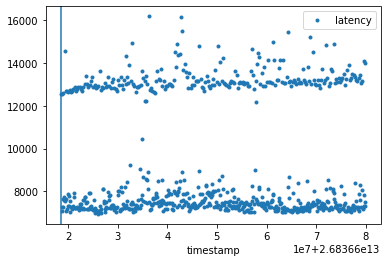

In [11]:
df.plot('timestamp', 'latency', marker='.', ls='')
plt.axvline(unknow_max_t)

In [10]:
# map_df[pd.isna(map_df.qdepth)==False].copy(deep=True).plot('arrive_t', 'latency', marker='.', ls='')
# df = map_df[pd.isna(map_df.qdepth)==False].copy(deep=True)
# unknow_max_t = df[df.lier=='unknow'].timestamp.max()
# print(unknow_max_t)
# df[df.path_str=='s12,s9,s2,s5,s7,'].plot('arrive_t', 'latency', marker='.', ls='')
# plt.axvline(unknow_max_t)
# if not np.isnan(unknow_max_t):
#     df = df[df['timestamp']>unknow_max_t] # cut off the beginnning of exp
# df[df.path_str=='s12,s9,s2,s5,s7,'].plot('arrive_t', 'latency', marker='.', ls='')

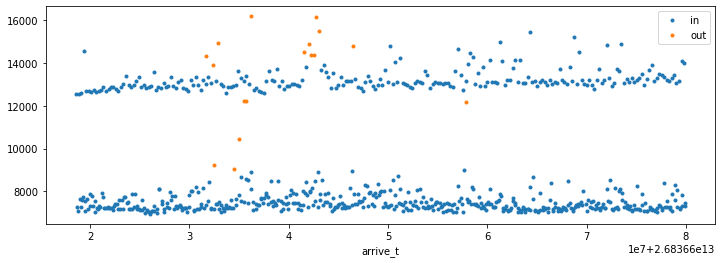

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 4)) 
for lier, sdf in df.groupby('lier'):
    sdf.plot('arrive_t', 'latency', ax=axes, label=lier, ls='', marker='.')

In [12]:
spmf_name = 'slot2_ipynb'
spmf_input_fn = f'spmf/{spmf_name}_input'
export_FSP(R_df, spmf_input_fn)
min_support = 0
spmf = Spmf("PrefixSpan", 
            arguments=[min_support, 2], # max pattern len = 2
            input_filename=f"./build/{spmf_input_fn}.txt",
            output_filename=f"./build/spmf/{spmf_name}_output.txt", 
            spmf_bin_location_dir="./analysis")
spmf.run()

spmf_df = spmf.to_pandas_dataframe()
frequentPatterns = spmf_df['pattern'].to_list()

In [13]:
diff_df = diff(frequentPatterns, R_df, S_df, th_supp=0., th_rr=1)
diff_df_raw = diff_df.copy()
diff_df

,pattern,support,score,len
0,"s1,s3,",0.958333,94.682676,2
1,"s5,s1,",0.958333,94.682676,2
2,"s3,",0.958333,52.146769,1
3,"s1,",0.975000,29.192849,1
4,"s5,",0.985000,17.054476,1


In [14]:
# 合并 support 一样的项目
for dup_sup in diff_df[diff_df.duplicated('support')]['support'].unique():
    longest = []
    dup_df = diff_df[diff_df['support']==dup_sup].sort_values('len')
    longest = dup_df['pattern'].to_list()[-1]
    for index, row in dup_df[:-1].iterrows():
        if row['pattern'] in longest:
            diff_df.drop(index, inplace=True)
print("diff merged")
diff_df.head()

diff merged


,pattern,support,score,len
0,"s1,s3,",0.958333,94.682676,2
1,"s5,s1,",0.958333,94.682676,2
2,"s3,",0.958333,52.146769,1
3,"s1,",0.975000,29.192849,1
4,"s5,",0.985000,17.054476,1


# RCA

In [15]:
sw_df = diff_df_raw[diff_df_raw['len']<=2]
sw_df

,pattern,support,score,len
0,"s1,s3,",0.958333,94.682676,2
1,"s5,s1,",0.958333,94.682676,2
2,"s3,",0.958333,52.146769,1
3,"s1,",0.975000,29.192849,1
4,"s5,",0.985000,17.054476,1


In [16]:
def find_fork(paths):
    paths = sorted(paths)
    fork = -1

    if len(paths) > 1:
        fork = -1
        for i in range(len(paths[0])):
            hops = [p[i] for p in paths]
            if len(set(hops)) > 1:
                fork = i - 1
                break
    
    return fork

In [17]:
def analysis_ecmp_imbalance(rca_, df, topo, timespan, ECMP_THRESHOLD):
    cf = rca_['culprit'].strip(',').split(',') # culprit flow
    # cf = "s5,s2,s3,".strip(',').split(',')
    cut_len = int((timespan[1] - timespan[0])/1e7)
    cut_len = 3
    backup_paths = sorted([p for p in topo.get_shortest_paths_between_nodes(cf[0], cf[-1]) if 's0' not in p])
    if len(backup_paths) == 1:
        return rca_
    
    fork_idx = find_fork(backup_paths)
    if fork_idx == -1:
        return rca_
    # print(backup_paths, fork_idx)
    timespan_df = df[(df.timestamp >= timespan[0]) & (df.timestamp <= timespan[1])].copy(deep=True)
    if len(timespan_df) == 0:
        return rca_
    timespan_df['epoch'] = pd.cut(timespan_df['receive_t'], cut_len, labels=list(range(cut_len)))
    
    flow_size = np.zeros(shape=(len(backup_paths), cut_len))
    for epoch, sdf in timespan_df.groupby(['epoch']):
        for pi, bp in enumerate(backup_paths):
            ssdf = sdf[sdf.path_str==",".join(bp)+","]
            flow_size[pi, epoch] = ssdf.path_pkt_size.sum()
    flow_size = flow_size[:, flow_size.sum(axis=0) != 0] # 去掉和为0的，避免处以0报错
    flow_ratio = flow_size/flow_size.sum(axis=0)
    flow_ratio = flow_ratio[:, (flow_ratio != 1).all(axis=0)]
    rca_.update(dict(ecmp=flow_ratio))
    if (flow_ratio > ECMP_THRESHOLD).any():
        rca_.update(dict(culprit=backup_paths[0][fork_idx], kind='ecmp imbalance', value=flow_ratio.max(), test=cf))
        rca_["comment"] = rca_.get('comment', "") + str(flow_ratio)
    return rca_


In [18]:
class PPS():
    def __init__(self, df, timespan, pre_offset=10, self_detect=False):
        if self_detect:
            self.timespan = detect_abnormal_timespan(df)
        else:
            self.timespan = timespan
        begin_t, end_t = self.timespan
        self.abnormal = self.cal_pps(
            df[(df['timestamp'] > begin_t) & (df['timestamp'] < end_t)])

        normal_df = df[df['timestamp'] < begin_t]
        if len(normal_df) < pre_offset:
            normal_df = df.reset_index(drop=True)[:pre_offset]
        self.normal = self.cal_pps(normal_df)

        # pps 变化率
        if self.normal == 0 and self.abnormal > 0:
            self.rate = np.inf
        else:
            self.rate = np.divide(self.abnormal - self.normal,
                                  self.normal)

    def cal_pps(self, df):
        tstamps = df['timestamp'].to_list()
        if len(set(tstamps)) > 2:
            return len(df) / ((max(tstamps) - min(tstamps))/1e6)  # pps
        else:
            return 0

In [19]:
DEPTH_STD_THRESHOLD = 2
PPS_THRESHOLD = 1.2
ECMP_THRESHOLD = 0.7 # 100%


def printf(*args, **kwrag):
    if 1:
        print(*args, **kwrag)
        
hosts = hosts.rename(columns={'qdepth_sum': 'qdepth'})

rca_data = []
for _, sw_row in sw_df.iterrows():
    # switch or link
    culprit_pos = sw_row.pattern
    printf(f"\nculprit postion is at {culprit_pos}")
    
    # if culprit_pos != "s1,s3,": continue
    
    #: flow with more count is more suspesious
        #: `value_counts()` return descending order defaultly
    culprit_flows_series = R_df[R_df['path_str'].str.contains(culprit_pos)].value_counts('path_str') 
    flow_total_counts = culprit_flows_series.values.sum()

    for culprit_flow, count in culprit_flows_series.items():
        #: culprit fow: travers culprit position (culprit_pos) most time 
        # printf('culprit flow:', culprit_flow)
        # culprit_flow_df = df[df.path_str==culprit_flow].copy(deep=True)
        culprit_flow_df = df[df.path_str==culprit_flow].copy(deep=True)
        timespan = detect_abnormal_timespan(culprit_flow_df)
        # timespan = (min(digests.timestamp), max(digests.timestamp))
        printf(timespan)
        if len(timespan)==0: # fail to detect abnormal timespan
            printf("fail to find abnormal timespan")
            continue

        qdepthes = culprit_flow_df['qdepth'].tolist() # global list of queue depth
        culprit_flow_dep_std = np.std(qdepthes)
        printf(f"abnormal flow ({culprit_flow}) qdepth std: {culprit_flow_dep_std:.2f}")

        general_score = sw_row.score * (count / flow_total_counts)

        rca_ = {'general_score': general_score, 'abnormal_pos': culprit_pos, 'abnormal_flow': culprit_flow, 'len': sw_row.len}

        if culprit_flow_dep_std < DEPTH_STD_THRESHOLD and 'kind' not in rca_:
            #: queue did not buildup in a sudden
            # print(culprit_flow_dep_std)
            # break
            rca_.update(dict(kind="switch link", 
                             culprit=culprit_pos, value=culprit_flow_dep_std))

        # cut timespan
        pps_rate_dict = {p: PPS(flow_dfs[p], timespan, self_detect=True) 
                         for p in flow_dfs.keys()}
        # pps_rate_dict = {flow: PPS(sdf, timespan) for flow, sdf in df.groupby(['flow'])}

        cul_pps = pps_rate_dict[culprit_flow]
        printf(f"abnormal flow pps: {cul_pps.normal:.2f}->{cul_pps.abnormal:.2f} ({'+' if cul_pps.rate>0 else ''}{cul_pps.rate*100:.1f}%)")
        # print(cul_pps.rate)

        rca_.update(dict(pps=cul_pps.rate))
        if cul_pps.rate > PPS_THRESHOLD and 'kind' not in rca_:
            rca_.update(dict(kind='flow', 
                             culprit=culprit_flow, value=cul_pps.rate))
            # print(f"root cause: flow ({culprit_flow})")

        pps_rate_sorted = sorted(pps_rate_dict.items(), key=lambda x: x[1].rate, reverse=True)
        printf(f"1st diff pps ({pps_rate_sorted[0][0]}): {pps_rate_sorted[0][1].abnormal:.1f} ({pps_rate_sorted[0][1].rate*100:.1f}%)")
        # if pps_rate_sorted[0][1].rate == np.inf:
        #     print(f"2nd abnormal pps: {pps_rate_sorted[1][1].abnormal:.1f}")
        if pps_rate_sorted[0][1].rate > PPS_THRESHOLD and 'kind' not in rca_:
            printf('flow', pps_rate_sorted[0][0])
            rca_.update(dict(kind='flow', 
                             pps=pps_rate_sorted[0][1].rate,
                             culprit=pps_rate_sorted[0][0], comment=f"first({pps_rate_sorted[0][0]});", value=pps_rate_sorted[0][1].rate))
        
        if 'kind' not in rca_:
            rca_.update(dict(kind='port queue rate', 
                             culprit=culprit_pos, comment=cul_pps.rate))

        
        if rca_['kind'] == "flow":
            rca_ = analysis_ecmp_imbalance(rca_, df, topo, timespan, ECMP_THRESHOLD)
        
        rca_data.append(rca_)
        
    #     break
    # break

rca_df = pd.DataFrame(rca_data).sort_values('len').sort_values('general_score', ascending=False, ignore_index=True)
rca_df.head()


culprit postion is at s1,s3,
(14821495161466, 14821497017089)
abnormal flow (s5,s1,s3,) qdepth std: 0.85
abnormal flow pps: 15.07->38.44 (+155.1%)
1st diff pps (s6,s2,s5,): 45.0 (172.8%)

culprit postion is at s5,s1,
(14821495161466, 14821497017089)
abnormal flow (s5,s1,s3,) qdepth std: 0.85
abnormal flow pps: 15.07->38.44 (+155.1%)
1st diff pps (s6,s2,s5,): 45.0 (172.8%)

culprit postion is at s3,
(14821495161466, 14821497017089)
abnormal flow (s5,s1,s3,) qdepth std: 0.85
abnormal flow pps: 15.07->38.44 (+155.1%)
1st diff pps (s6,s2,s5,): 45.0 (172.8%)

culprit postion is at s1,
(14821495161466, 14821497017089)
abnormal flow (s5,s1,s3,) qdepth std: 0.85
abnormal flow pps: 15.07->38.44 (+155.1%)
1st diff pps (s6,s2,s5,): 45.0 (172.8%)
(14821519207096, 14821517412938)
abnormal flow (s4,s1,s5,) qdepth std: 2.96
abnormal flow pps: 20.69->22.39 (+8.2%)
1st diff pps (s6,s2,s5,): 45.0 (172.8%)
flow s6,s2,s5,

culprit postion is at s5,
(14821495161466, 14821497017089)
abnormal flow (s5,s1,s3

,general_score,abnormal_pos,abnormal_flow,len,kind,culprit,value,pps,comment,ecmp,test
0,94.682676,"s1,s3,","s5,s1,s3,",2,switch link,"s1,s3,",0.853234,1.550872,NaN,NaN,NaN
1,94.682676,"s5,s1,","s5,s1,s3,",2,switch link,"s5,s1,",0.853234,1.550872,NaN,NaN,NaN
2,52.146769,"s3,","s5,s1,s3,",1,switch link,"s3,",0.853234,1.550872,NaN,NaN,NaN
3,28.693826,"s1,","s5,s1,s3,",1,switch link,"s1,",0.853234,1.550872,NaN,NaN,NaN
4,16.592765,"s5,","s5,s1,s3,",1,switch link,"s5,",0.853234,1.550872,NaN,NaN,NaN


In [20]:
rca_df

,general_score,abnormal_pos,abnormal_flow,len,kind,culprit,value,pps,comment,ecmp,test
0,94.682676,"s1,s3,","s5,s1,s3,",2,switch link,"s1,s3,",0.853234,1.550872,NaN,NaN,NaN
1,94.682676,"s5,s1,","s5,s1,s3,",2,switch link,"s5,s1,",0.853234,1.550872,NaN,NaN,NaN
2,52.146769,"s3,","s5,s1,s3,",1,switch link,"s3,",0.853234,1.550872,NaN,NaN,NaN
3,28.693826,"s1,","s5,s1,s3,",1,switch link,"s1,",0.853234,1.550872,NaN,NaN,NaN
4,16.592765,"s5,","s5,s1,s3,",1,switch link,"s5,",0.853234,1.550872,NaN,NaN,NaN
5,0.499023,"s1,","s4,s1,s5,",1,flow,"s6,s2,s5,",1.727587,1.727587,"first(s6,s2,s5,);",NaN,NaN
6,0.288570,"s5,","s4,s1,s5,",1,flow,"s6,s2,s5,",1.727587,1.727587,"first(s6,s2,s5,);",NaN,NaN
7,0.144285,"s5,","s4,s2,s5,",1,ecmp imbalance,s6,0.980285,1.727587,"first(s6,s2,s5,);[[0.98028457]\n [0.01971543]]","[[0.9802845691193994], [0.0197154308806006]]","[s6, s2, s5]"
8,0.028857,"s5,","s6,s2,s5,",1,switch link,"s5,",0.825000,1.727587,NaN,NaN,NaN


In [21]:
# cf = rca_['culprit'].strip(',').split(',') # culprit flow
# # cf = "s5,s2,s3,".strip(',').split(',')
# cut_len = int((timespan[1] - timespan[0])/1e7)
# cut_len = 3
# backup_paths = sorted([p for p in topo.get_shortest_paths_between_nodes(cf[0], cf[-1]) if 's0' not in p])

# fork_idx = find_fork(backup_paths)
# # print(backup_paths, fork_idx)
# timespan_df = df[(df.timestamp >= timespan[0]) & (df.timestamp <= timespan[1])].copy(deep=True)
# timespan_df['epoch'] = pd.cut(timespan_df['receive_t'], cut_len, labels=list(range(cut_len)))

# flow_size = np.zeros(shape=(len(backup_paths), cut_len))
# for epoch, sdf in timespan_df.groupby(['epoch']):
#     for pi, bp in enumerate(backup_paths):
#         ssdf = sdf[sdf.path_str==",".join(bp)+","]
#         flow_size[pi, epoch] = ssdf.path_pkt_size.sum()
# flow_size = flow_size[:, flow_size.sum(axis=0) != 0] # 去掉和为0的，避免处以0报错
# flow_ratio = flow_size/flow_size.sum(axis=0)
# flow_ratio = flow_ratio[:, (flow_ratio != 1).all(axis=0)]
# rca_.update(dict(ecmp=flow_ratio))
# if (flow_ratio > ECMP_THRESHOLD).any():
#     rca_.update(dict(culprit=backup_paths[0][fork_idx], kind='ecmp imbalance', value=flow_ratio.max(), test=cf))
#     rca_["comment"] = rca_.get('comment', "") + str(flow_ratio)

In [22]:
culprit_flow = 's20,s17,s2,s13,s15,'
pps = PPS(hosts[hosts.path_str==culprit_flow], timespan, self_detect=True)
pps.__dict__

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


{'timespan': [0, 0], 'abnormal': 0, 'normal': 0, 'rate': nan}

In [23]:
from scipy.signal import savgol_filter
def continue_idx(arr):
    '''called by detect_abnormal_timespan'''
    count = 0
    effect_index = []
    for i in range(len(arr)-1):
        if arr[i] + 1 != arr[i+1]:  # continue end
            if count != 0:
                effect_index[-1][1] = count  # udpate count
                count = 0  # refresh count
            continue
        else:
            if count == 0:
                effect_index.append([arr[i], 1])
            count += 1
            if i == len(arr)-2:  # the last one
                effect_index[-1][1] = count  # udpate count
    return sorted(effect_index, key=lambda x: x[1], reverse=True)
def detect_abnormal_timespan(culprit_flow_df):
    '''return begin time and end time of abnormal timespan'''
    if len(culprit_flow_df) < 11:
        return [0, 0]
    smooth = savgol_filter(culprit_flow_df['latency'].to_list(), 11, 1)
    grad = np.gradient(smooth)
    std = np.std(grad)

    over_std = np.where(grad > std/2)[0]
    below_std = np.where(grad < -std/2)[0]

    begin_indexs = continue_idx(over_std)
    if not begin_indexs:
        return [0, 0]
    begin_index = begin_indexs[0][0]

    end_indexs = continue_idx(below_std)
    if end_indexs:
        end_index = end_indexs[0]
        end_index = end_index[0] + end_index[1]
    else:
        end_index = max(over_std)

    timestamps = culprit_flow_df['timestamp'].tolist()
    begin_t = timestamps[begin_index]
    end_t = timestamps[end_index]
    return begin_t, end_t

In [24]:
culprit_flow_df = df[df.path_str==culprit_flow]
timespan = detect_abnormal_timespan(culprit_flow_df)

In [25]:

# smooth = savgol_filter(culprit_flow_df['latency'].to_list(), 11, 1)
# grad = np.gradient(smooth)
# std = np.std(grad)

# over_std = np.where(grad > std/2)[0]
# below_std = np.where(grad < -std/2)[0]

# begin_indexs = continue_idx(over_std)

# begin_index = begin_indexs[0][0]

# end_indexs = continue_idx(below_std)
# if end_indexs:
#     end_index = end_indexs[0]
#     end_index = end_index[0] + end_index[1]
# else:
#     end_index = max(over_std)

# timestamps = culprit_flow_df['timestamp'].tolist()
# begin_t = timestamps[begin_index]
# end_t = timestamps[end_index]

In [26]:
# culprit_flow_df.plot('timestamp', 'latency', marker='.', ls='')
# for t in timespan:
#     plt.axvline(t, c='r', alpha=0.5)
# print(timespan)
# pps = PPS(culprit_flow_df, timespan, self_detect=True)
# pps.__dict__

In [27]:
# cut_len = 50
# hosts['epoch'] = pd.cut(hosts['receive_t'], cut_len, labels=list(range(cut_len)))
# epoch_count = []
# fork_sw = 's5'
# for epoch, sdf in hosts.groupby(['epoch']):
#     for core_sw in ['s1', 's2']:
#         # c = len(sdf[sdf.whole_path.str.contains(f'{core_sw},{sink_sw},')])
#         pattern = f'{fork_sw},{core_sw},'
#         ssdf = sdf[sdf.whole_path.str.contains(pattern)]
#         for path, sssdf in ssdf.groupby(['whole_path']):
#             c = sssdf['src_count'].sum()
#             epoch_count.append(dict(
#                 epoch=epoch,
#                 core_sw=core_sw,
#                 count=c,
#                 label=path,
#             ))

In [28]:
rca_merge = []
for culprit in rca_df['culprit'].unique():
    # print(culprit)
    cul_df = rca_df[rca_df['culprit']==culprit]
    for kind in cul_df['kind'].unique():
        kind_df = cul_df[cul_df['kind']==kind]

        # general_score=kind_df['general_score'].to_numpy().sum()
        # print(general_score)
        if kind == "flow": 
            general_score=max(kind_df['general_score']) # TODO:
            # general_score=sum(kind_df['general_score'])
        else:
            general_score=sum(kind_df['general_score'])
        rca_temp = dict(
            general_score=general_score,
            abnormal_pos=kind_df['abnormal_pos'].unique(),
            abnormal_flow=kind_df['abnormal_flow'].unique(),
            culprit=culprit,
            kind=kind
        )

        if culprit.count(',') == 1: # single switch
            suggestion_df = rca_df[
                    (rca_df['culprit'].str.contains(culprit)) & 
                    (rca_df['len']>1)
                ]
            if general_score == np.inf:
                suggestion_df = suggestion_df[suggestion_df['general_score'].rank(method='dense', ascending=False)==1]
            else:
                suggestion_df = suggestion_df[suggestion_df['general_score']==general_score]
            rca_temp['suggestion'] = suggestion_df['culprit'].unique()

        rca_merge.append(rca_temp)
    # break

rca_merge_df = pd.DataFrame(rca_merge).sort_values('general_score', ascending=False, ignore_index=True)#.reset_index(drop=True)


In [29]:
rca_merge_df

,general_score,abnormal_pos,abnormal_flow,culprit,kind,suggestion
0,94.682676,"[s1,s3,]","[s5,s1,s3,]","s1,s3,",switch link,NaN
1,94.682676,"[s5,s1,]","[s5,s1,s3,]","s5,s1,",switch link,NaN
2,52.146769,"[s3,]","[s5,s1,s3,]","s3,",switch link,[]
3,28.693826,"[s1,]","[s5,s1,s3,]","s1,",switch link,[]
4,16.621622,"[s5,]","[s5,s1,s3,, s6,s2,s5,]","s5,",switch link,[]
5,0.499023,"[s1,, s5,]","[s4,s1,s5,]","s6,s2,s5,",flow,NaN
6,0.144285,"[s5,]","[s4,s2,s5,]",s6,ecmp imbalance,NaN


In [30]:
flow_rca_df = rca_merge_df[rca_merge_df.kind=='flow'].copy(deep=True)
flow_rca = []
def get_sw_src_dst(path):
    path = path.rstrip(',').split(',')
    return f"{path[0]}-{path[-1]}"
flow_rca_df['suggestion'] = flow_rca_df.culprit.apply(get_sw_src_dst)
for flow_sd in flow_rca_df.suggestion.unique():
    flow_df = flow_rca_df[flow_rca_df.suggestion == flow_sd]
    flow_rca.append(dict(
        general_score=sum(flow_df.general_score),
        abnormal_pos=flow_df.abnormal_pos.tolist(),
        abnormal_flow=flow_df.culprit.tolist(),
        culprit=flow_sd,
        kind='flow',
    ))
rca_merge_df = rca_merge_df.drop(flow_rca_df.index)
rca_merge_df = rca_merge_df.append(pd.DataFrame(flow_rca))
rca_merge_df = rca_merge_df.sort_values('general_score', ascending=False, ignore_index=True)

rca_merge_df['rank'] = rca_merge_df['general_score'].rank(method='dense', ascending=False).astype(int)
# rca_merge_df['rank'] = rca_merge_df['rank'].astype(int)

# Result

In [31]:
print("RESULT!")
rca_merge_df

RESULT!


,general_score,abnormal_pos,abnormal_flow,culprit,kind,suggestion,rank
0,94.682676,"[s1,s3,]","[s5,s1,s3,]","s1,s3,",switch link,NaN,1
1,94.682676,"[s5,s1,]","[s5,s1,s3,]","s5,s1,",switch link,NaN,1
2,52.146769,"[s3,]","[s5,s1,s3,]","s3,",switch link,[],2
3,28.693826,"[s1,]","[s5,s1,s3,]","s1,",switch link,[],3
4,16.621622,"[s5,]","[s5,s1,s3,, s6,s2,s5,]","s5,",switch link,[],4
5,0.499023,"[[s1,, s5,]]","[s6,s2,s5,]",s6-s5,flow,NaN,5
6,0.144285,"[s5,]","[s4,s2,s5,]",s6,ecmp imbalance,NaN,6
